In [2]:
import librosa
import librosa.display
from scipy import signal
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import math
from PyHa.statistics import *
from PyHa.IsoAutio import *
from PyHa.visualizations import *

In [4]:
# Going to test with some Piha Calls, they usually peak a little bit above 5kHz, so I am going to bring the audio in
# at a 12kHz sample rate to reconstruct up to 6kHz
piha_clip_path = "data/test/ScreamingPiha2.wav"
y,sr = librosa.load(piha_clip_path,sr=12000)
S = np.abs(librosa.stft(y))

Text(0, 0.5, 'Frequency (0-6kHz)')

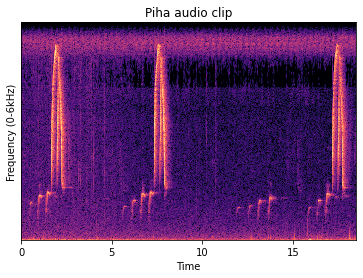

In [5]:
fig, ax = plt.subplots()
# Displaying a linear spectrogram. This y-limit is 6kHz.
# I really dislike the default settings found in Librosa for the x and y axis.
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), x_axis='time', ax=ax)
# It seems that 3s is a good time on this image.
plt.title("Piha audio clip")
plt.ylabel("Frequency (0-6kHz)")

Text(0.5, 1.0, 'Piha Template')

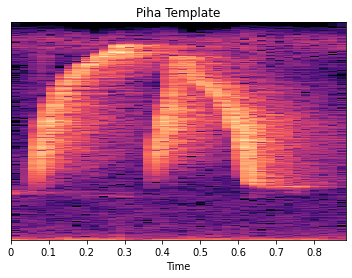

In [4]:
template = np.abs(librosa.stft(y[36000:55000]))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(template,ref=np.max),x_axis='time',ax=ax)
plt.title("Piha Template")

In [6]:
# performing the sound cross-correlation
# This is very slow
corr = signal.correlate2d(S,template,boundary='symm',mode='same')
corr_reduced_max = np.amax(corr,axis=0)

# Time to figure out how to connect this 1D local score array back into the Steinberg technique
# Setting up the Isolation Parameters
isolation_parameters = {
    "technique" : "steinberg",
    "threshold_type" : "median",
    "threshold_const" : 2.0,
    "threshold_min" : 0.0,
    "bi_directional_jump" : 0.05,
    "window_size" : 1.0 
}
# "bi_directional_jump" : len(y[36000:55000])/sr 

test_df = steinberg_isolate(corr_reduced_max/max(corr_reduced_max),y,12000,"test_dir","test_file",isolation_parameters)
test_df

,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,OFFSET,DURATION,MANUAL ID
0,test_dir,test_file,0,33.933083,12000,1.799500,3.597583,bird
1,test_dir,test_file,0,33.933083,12000,12.232417,3.512417,bird
2,test_dir,test_file,0,33.933083,12000,30.628417,3.171750,bird


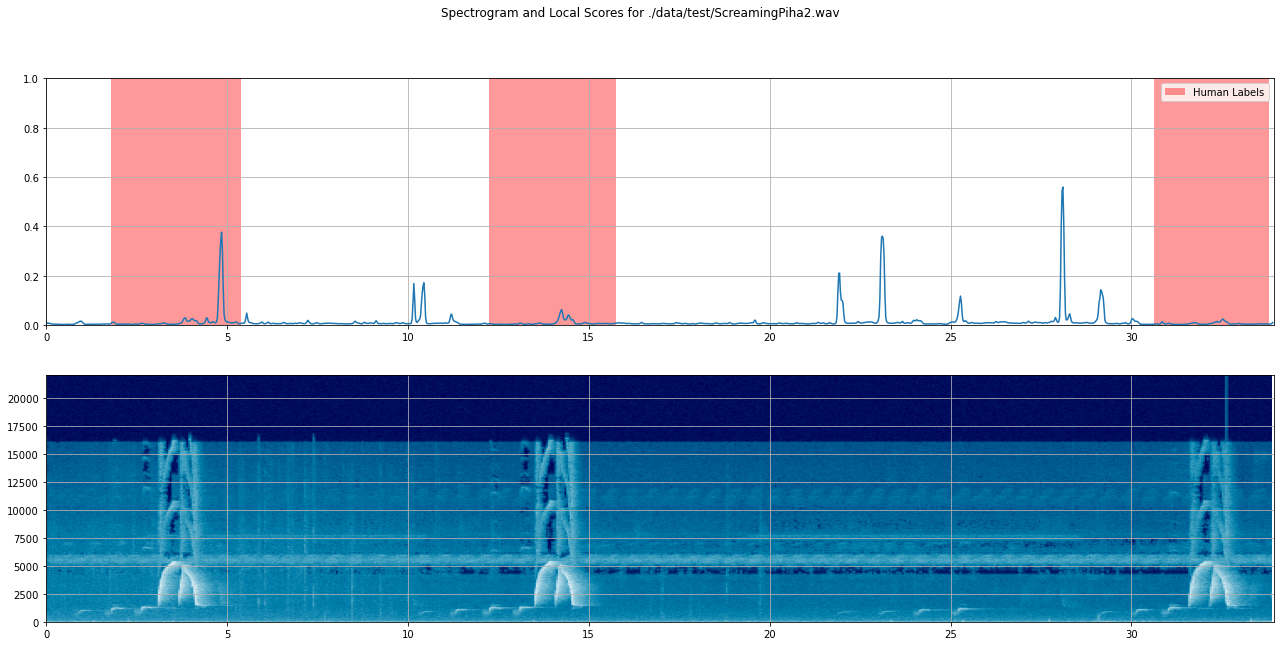

In [9]:
# The way Pyha is written right now, I need to pretend like these automated template matched annotations
# are human annotations. I wrote an issue to handle this later.
local_score_visualization("./data/test/ScreamingPiha2.wav", premade_annotations_df = test_df) 